##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\3.08"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

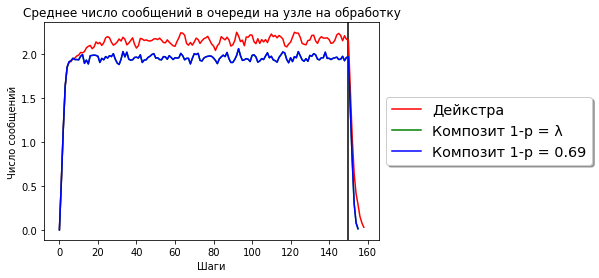

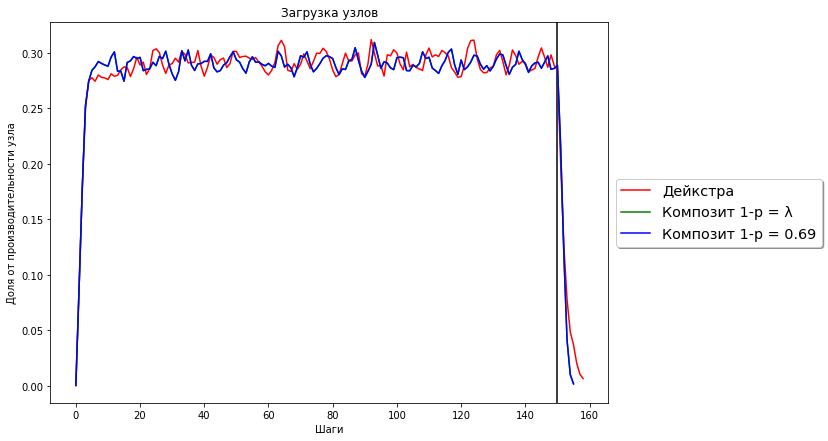

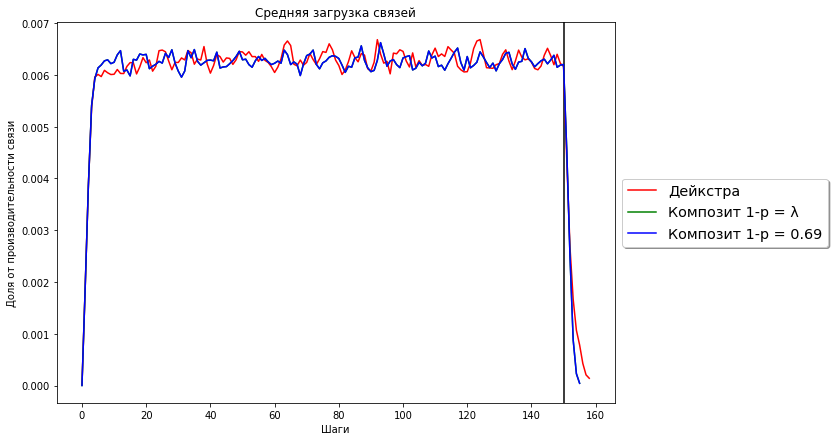

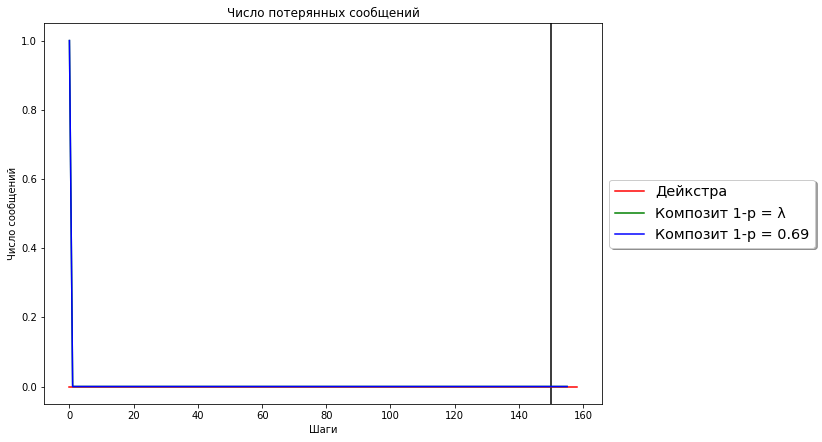

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.69


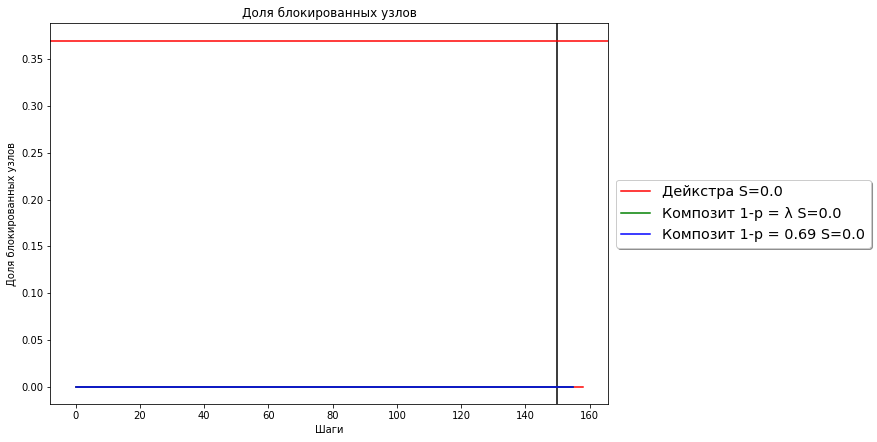

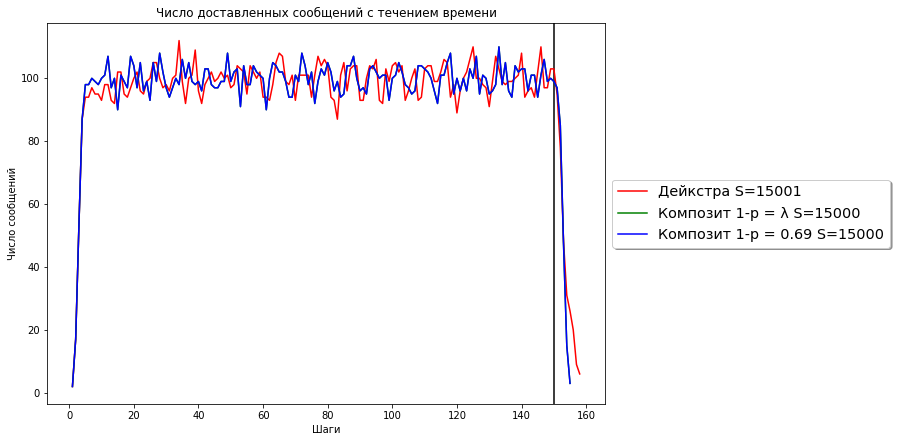

In [2]:
log_tags = [
 {"tag":  "0978e0b0-542d-4cb6-b5bf-872f2887d0b6", "label": "Дейкстра", "color": "red"},
# {"tag":  "2b650059-299c-4719-a35e-8e60331d0d22", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "9e6563e9-15e1-48bb-b87a-25ae64e5e2ff", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "2a1717ed-c369-4052-a443-030511f9c9ef", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
 
]
quantity = 100; 
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

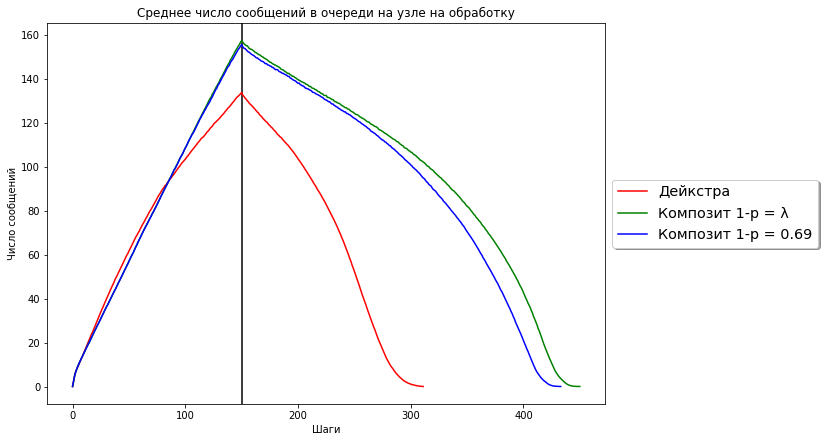

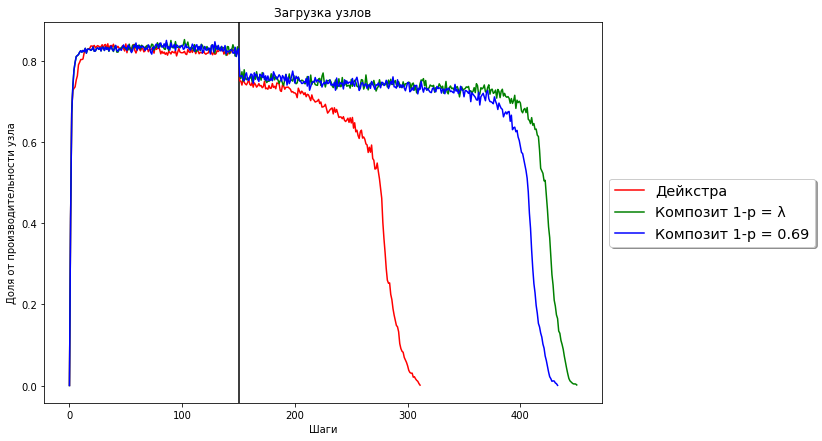

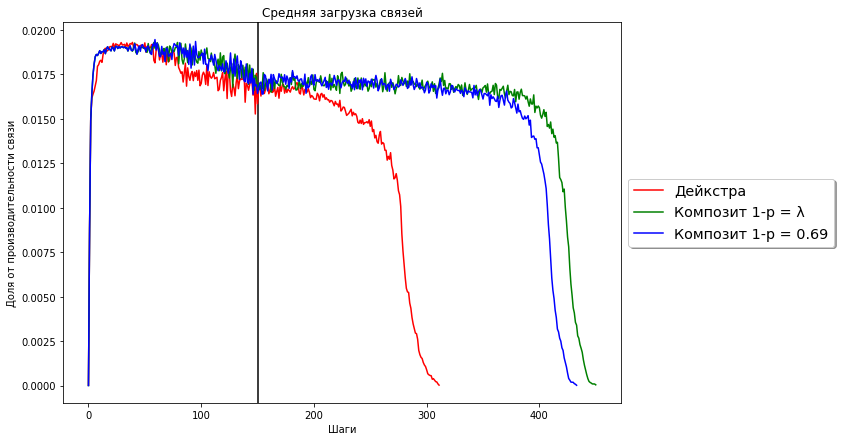

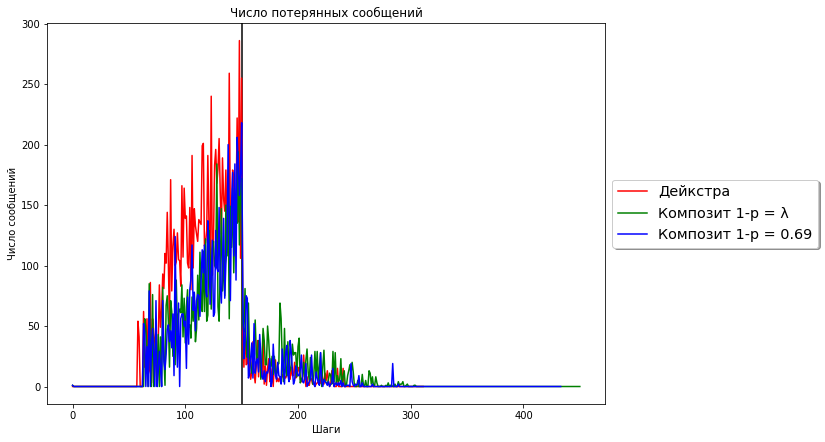

Доставлено 63215 Потеряно 15.7145% -Дейкстра
Доставлено 66309 Потеряно 11.5892% -Композит 1-p = λ
Доставлено 66970 Потеряно 10.7079% -Композит 1-p = 0.69


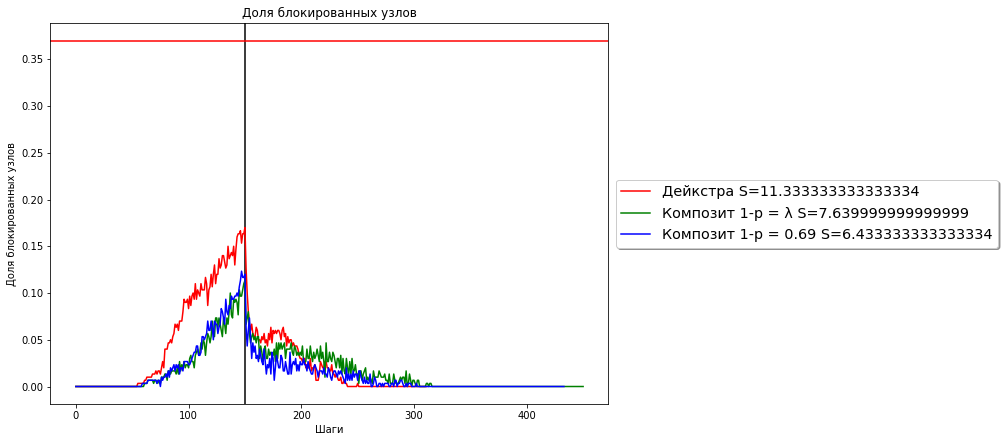

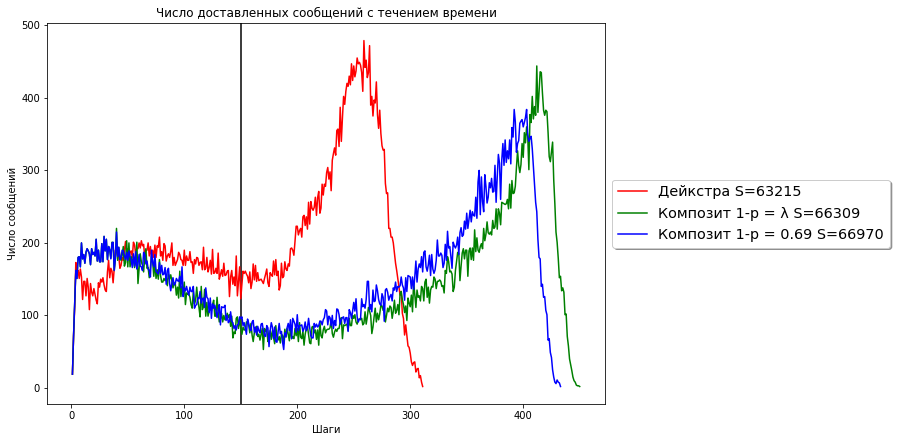

In [3]:
log_tags = [
 {"tag":  "d0c1df0d-a136-4685-ac79-39729c58f3bd", "label": "Дейкстра", "color": "red"},
 #{"tag":  "07b446ae-f69e-436d-8eb0-5ef918e50bce", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "1a97a2c6-da95-499c-a19a-3ed742a798ed", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "fd6f6d75-f6ee-4813-90b3-47071a7481b8", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

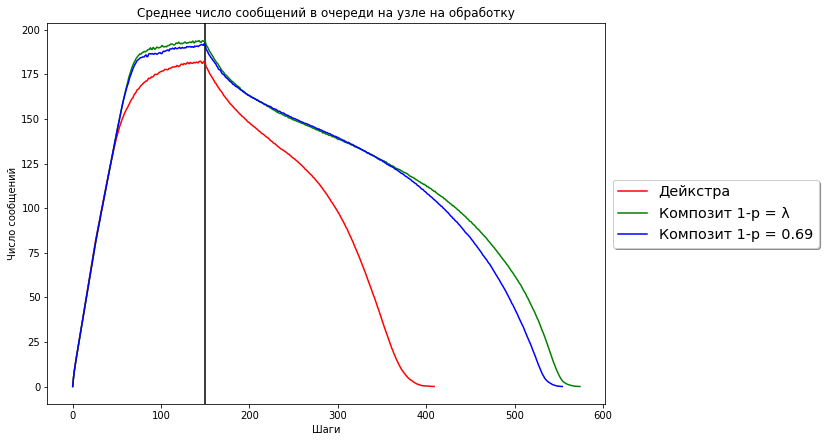

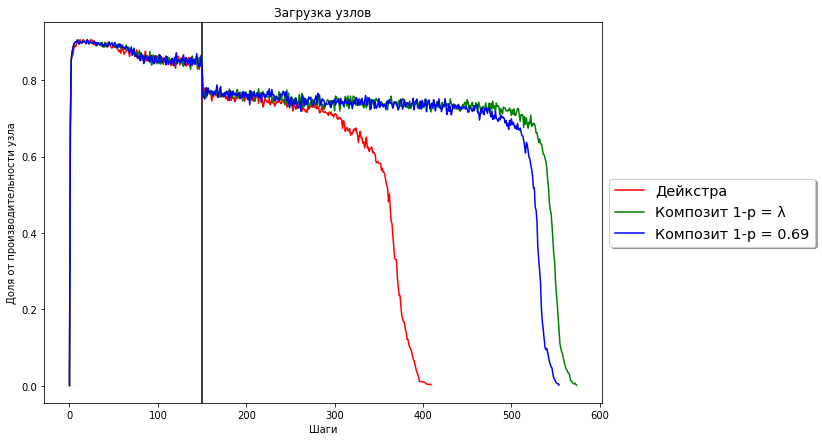

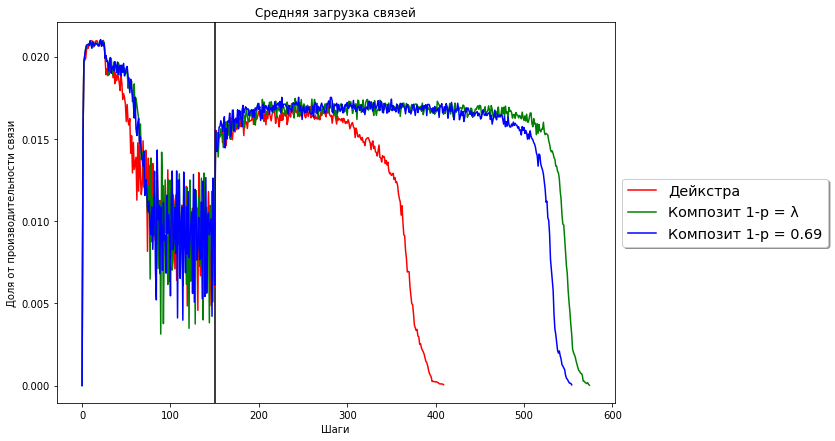

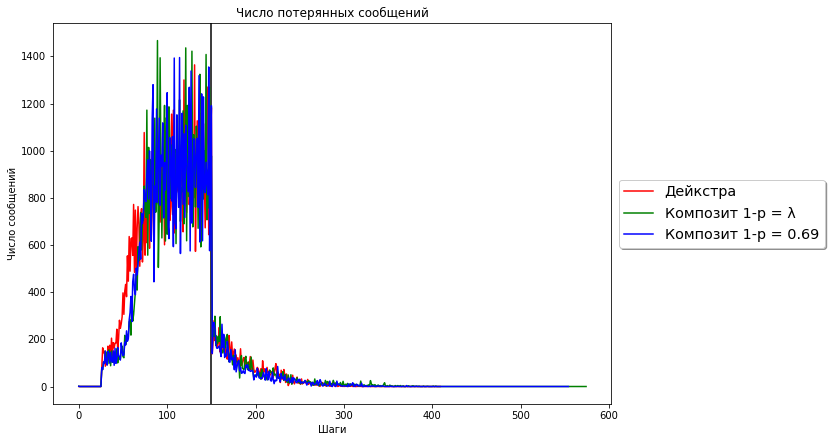

Доставлено 54764 Потеряно 63.4909% -Дейкстра
Доставлено 57305 Потеряно 61.7969% -Композит 1-p = λ
Доставлено 58072 Потеряно 61.2856% -Композит 1-p = 0.69


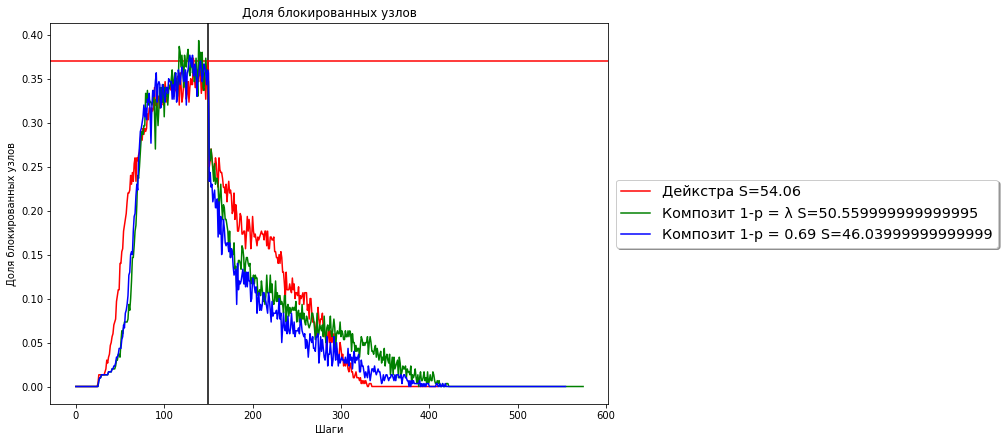

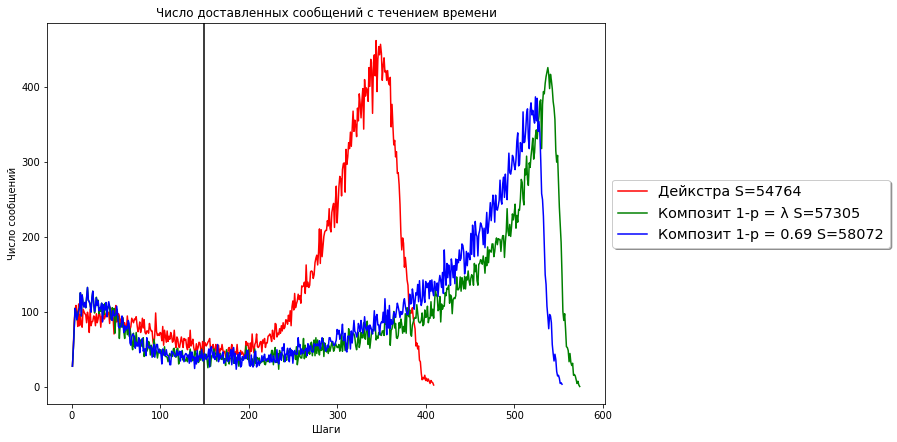

In [4]:
log_tags = [
 {"tag":  "c52639a9-c4c2-4ff8-a5c0-ac3086b33425", "label": "Дейкстра", "color": "red"},
 #{"tag":  "1155413f-6d21-499d-90b3-3e01b5de6bb3", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "6cf973c8-01f7-4ca3-b726-1f37d0643689", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "ac37c7a7-a53d-4806-840a-e3e65266b992", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

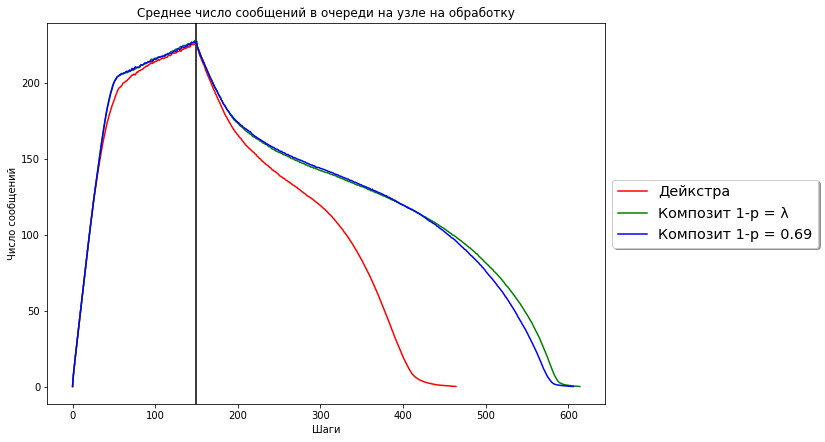

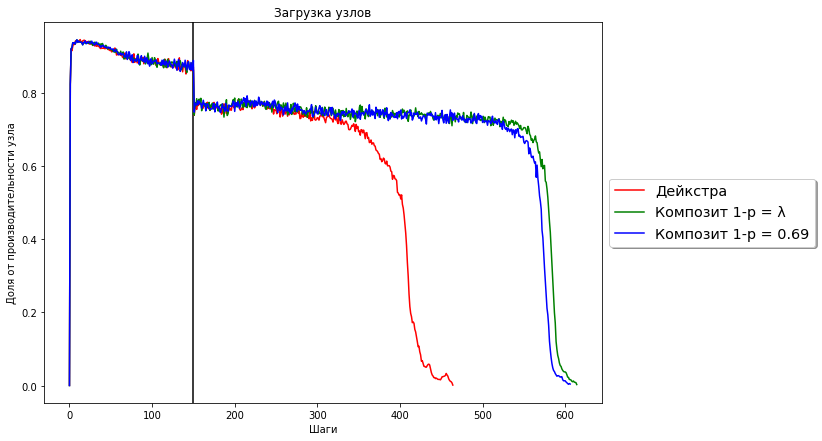

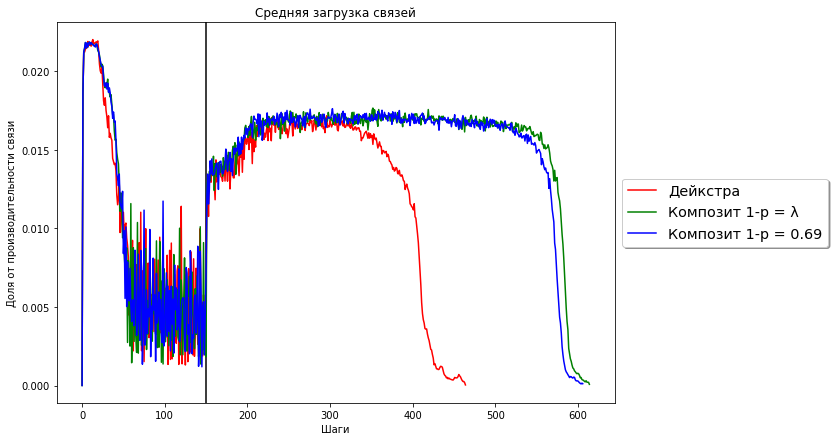

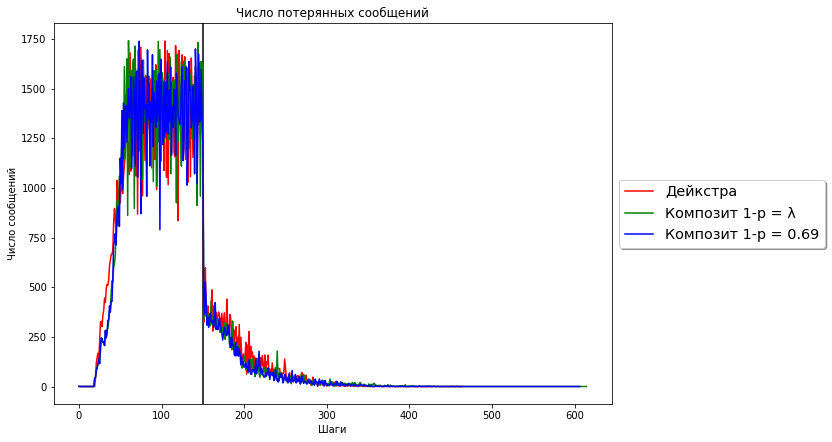

Доставлено 50910 Потеряно 77.3734% -Дейкстра
Доставлено 53893 Потеряно 76.0477% -Композит 1-p = λ
Доставлено 54888 Потеряно 75.6054% -Композит 1-p = 0.69


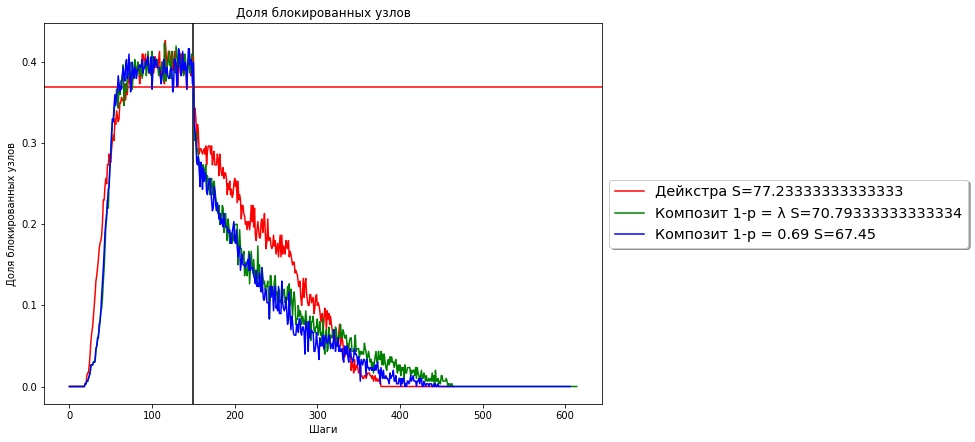

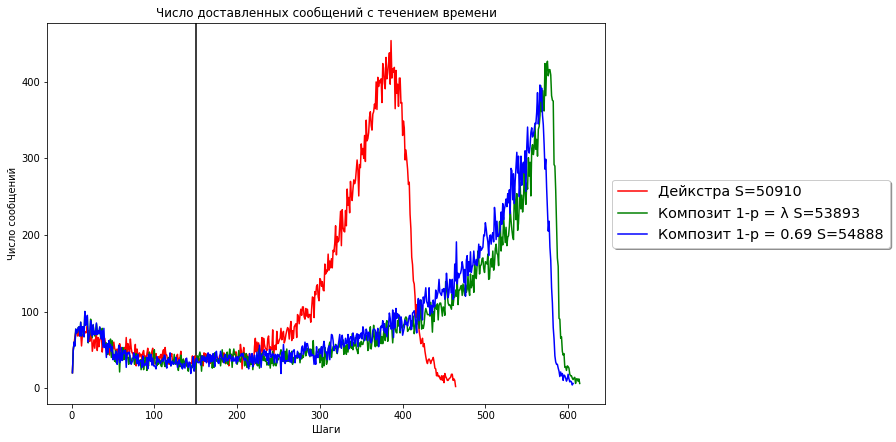

In [5]:
log_tags = [
 {"tag":  "68d2f567-2219-4314-ae76-1c7d5d669f63", "label": "Дейкстра", "color": "red"},
 #{"tag":  "4a376c54-9280-41b7-9d71-0bb8653f7014", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "c44c2d5b-b234-44d3-972c-e807e4b50d82", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b9cf7970-a269-410c-bb4c-46d78af234e4", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 44450 Потеряно 1.2244% -Дейкстра
Доставлено 44418 Потеряно 1.2955% -Композит 1-p = λ
Доставлено 44410 Потеряно 1.3133% -Композит 1-p = 0.69


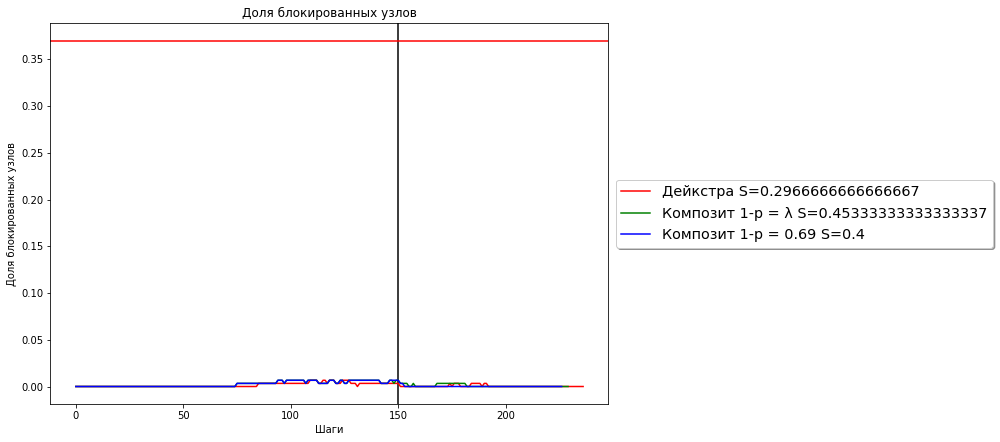

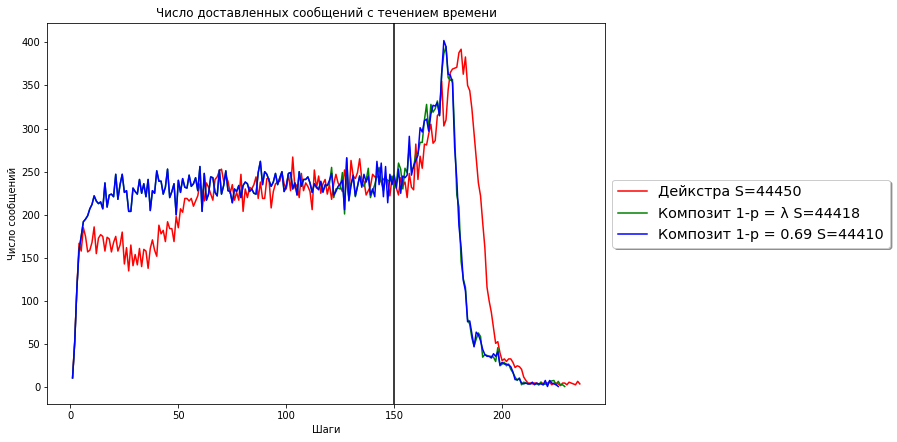

Доставлено 60886 Потеряно 42.0139% -Дейкстра
Доставлено 62218 Потеряно 40.7453% -Композит 1-p = λ
Доставлено 63507 Потеряно 39.5177% -Композит 1-p = 0.69


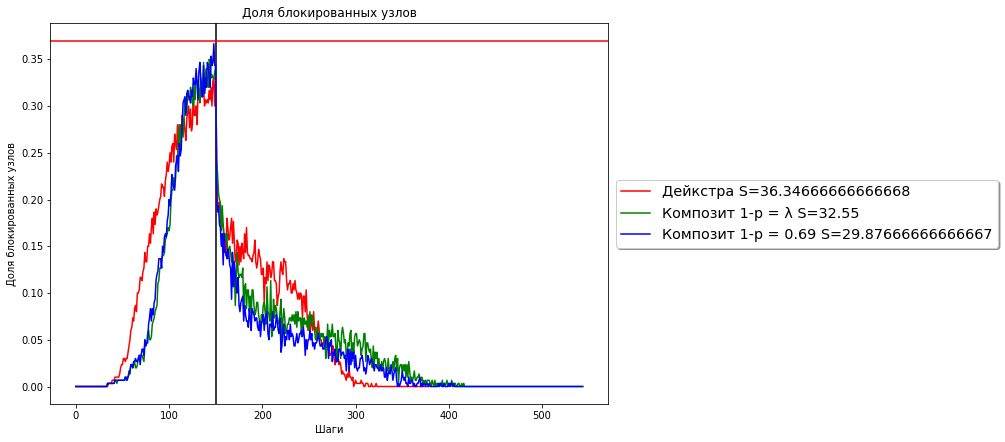

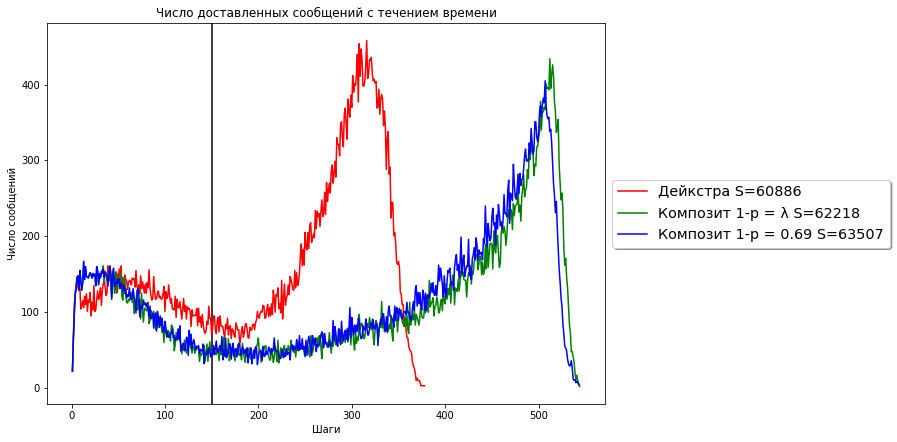

Доставлено 56636 Потеряно 58.0477% -Дейкстра
Доставлено 58818 Потеряно 56.4314% -Композит 1-p = λ
Доставлено 59647 Потеряно 55.8174% -Композит 1-p = 0.69


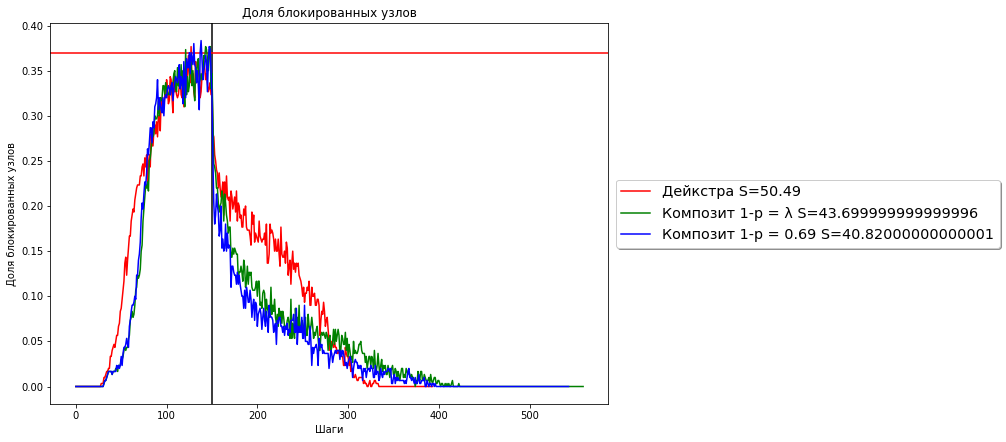

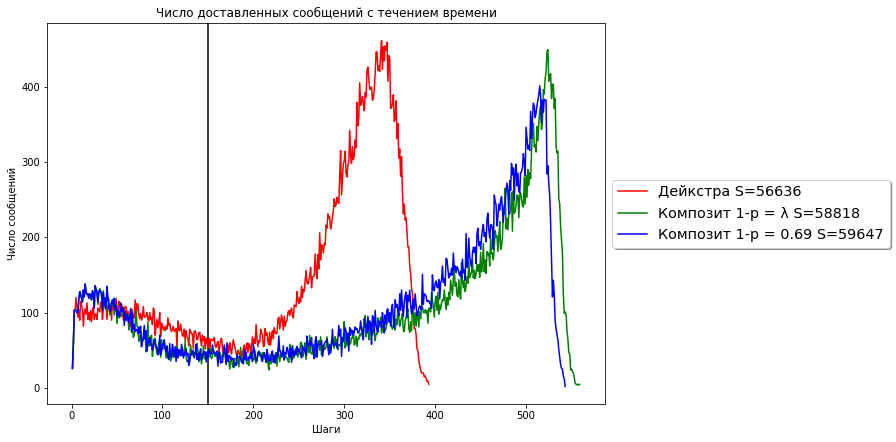

Доставлено 52693 Потеряно 72.9781% -Дейкстра
Доставлено 55929 Потеряно 71.3186% -Композит 1-p = λ
Доставлено 56733 Потеряно 70.9063% -Композит 1-p = 0.69


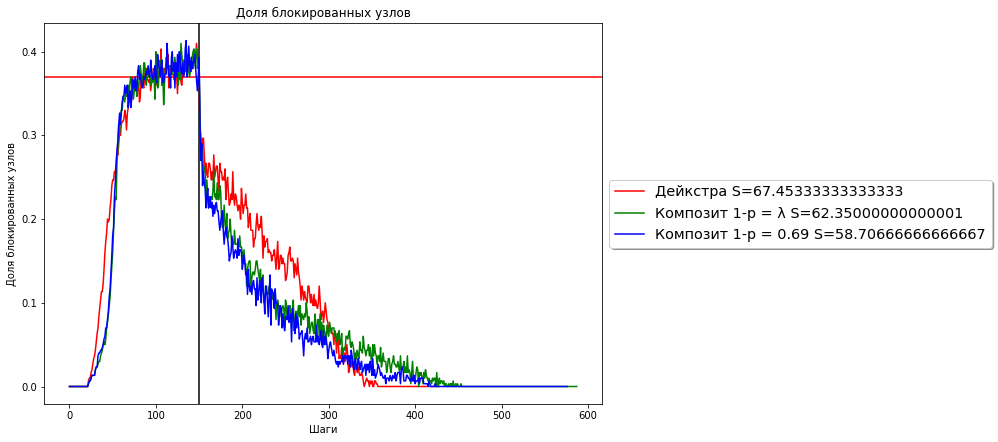

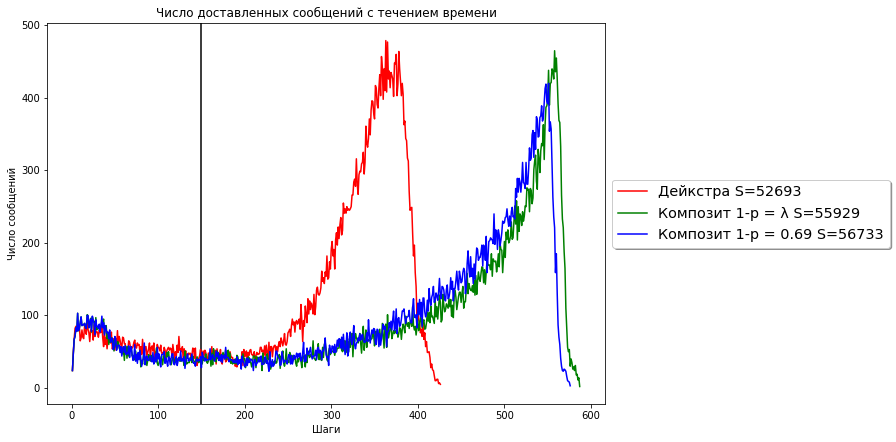

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "133d160e-bc59-4b57-a011-28477928d947", "label": "Дейкстра", "color": "red"},
 {"tag":  "2343db84-80dd-4470-b09c-537ff7e0856a", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "235a8d77-8266-4c52-9441-2ee7cd43b111", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "313870d7-5500-4d49-bc5d-3fa83cb1e230", "label": "Дейкстра", "color": "red"},
 {"tag":  "11c06c18-0588-43af-8cd9-5140edf48b1a", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "0d7501b8-cdd6-4bf8-9b89-8573beaa36fd", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "75db2610-1925-4533-bf67-f8a8e8a55cc9", "label": "Дейкстра", "color": "red"},
 {"tag":  "94f69eca-3575-485e-a8c5-a7307a6765d1", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "6a7b979e-a2ed-434e-b403-2df6accbc7cd", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "82f4f942-18bd-40b8-ace1-aa3fce92eaa7", "label": "Дейкстра", "color": "red"},
 {"tag":  "7eddd59d-0c50-4fc4-800d-a2c22cca73e4", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "bc2153dc-0bfb-4411-b955-1cd2681294eb", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

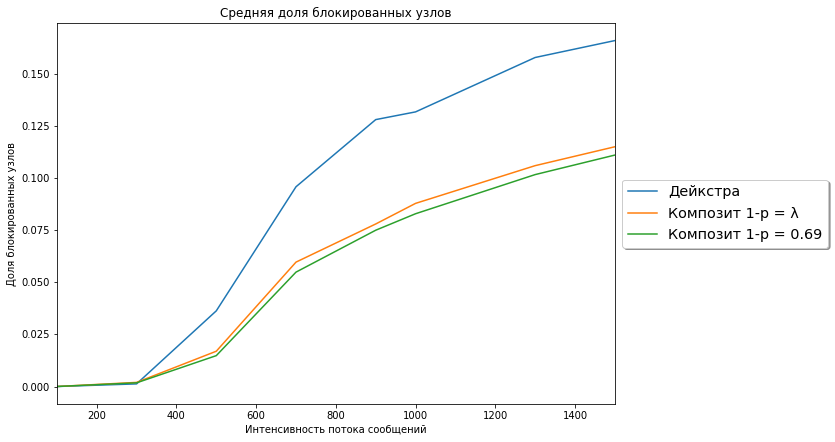

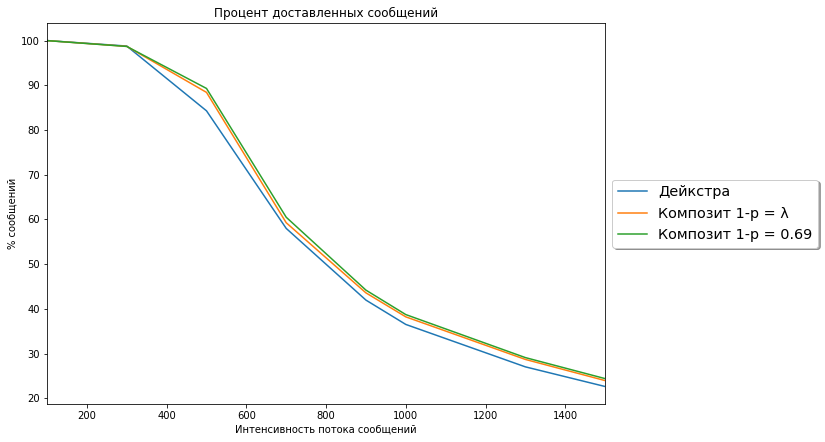

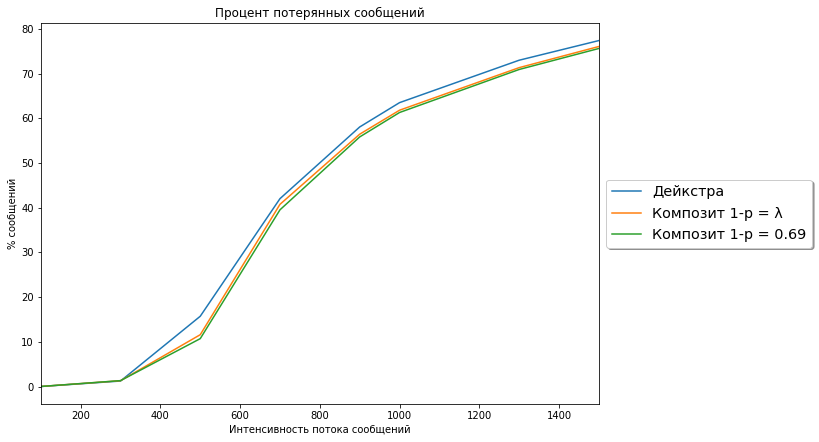

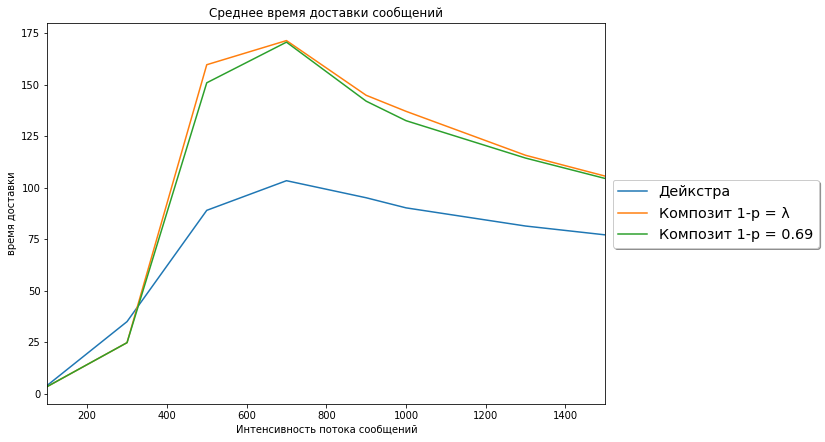

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.089693
Композит 1-p = λ       0.058219
Композит 1-p = 0.69    0.055295

Дейкстра               41.355364
Композит 1-p = λ       39.903915
Композит 1-p = 0.69    39.395031

Дейкстра                71.929529
Композит 1-p = λ       107.862231
Композит 1-p = 0.69    105.431487
